In [6]:
#Importing packages 
#import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from pdpbox import pdp, info_plots
import seaborn as sns

In [5]:
#Checking directory 
pwd

C:\Users\User\My_repo\Homework\Unit3\data


In [14]:
#Reading in data 
df = pd.read_csv('../data/insurance_premiums.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [49]:
#Checking number of observations 
df.count()

age         1338
sex         1338
bmi         1338
children    1338
smoker      1338
region      1338
charges     1338
dtype: int64

In [67]:
#Checking missing 
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

**No missing means we will not need to impute** 

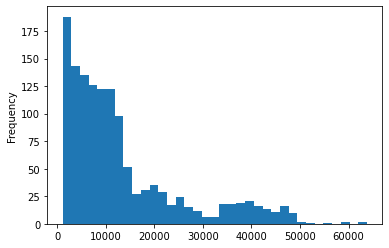

In [176]:
df.charges.plot(kind='hist', bins=35);

**Firstyl, by looking at the Y value, we see that most charges are below 30,000.**

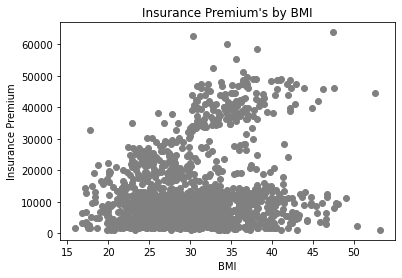

In [40]:
x_bmi = df.bmi
y_charges = df.charges
plt.plot(x_bmi, y_charges, 'o', color='gray');
plt.xlabel("BMI");
plt.ylabel("Insurance Premium");
plt.title("Insurance Premium's by BMI");

**BMI has a positive relationship, but does break off into two groups after BMI passes ~30. As discussed in class, this clearly shows a possible third variable at play.**

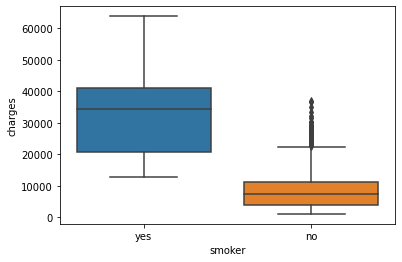

In [167]:
sns.boxplot(x="smoker", y="charges", data=df);

**As suspected smokers show higher insurance premiums than nonsmokers**

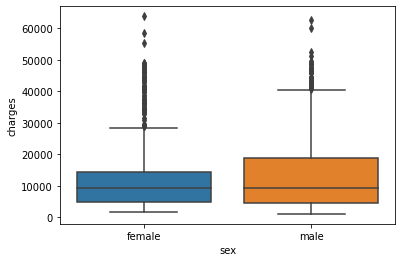

In [169]:
sns.boxplot(x="sex", y="charges", data=df);

**There doesn't seem to be a large difference between males and females in regards to insruance premiums. I would guess this value has little effect on insurance premiums.**

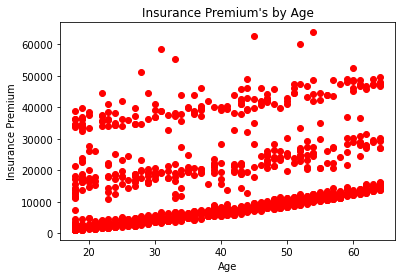

In [171]:
x_age = df.age
y_charges = df.charges
plt.plot(x_age, y_charges, 'o', color='red');
plt.xlabel("Age");
plt.ylabel("Insurance Premium");
plt.title("Insurance Premium's by Age");

**While age does show a slight positive relationship, there are clear signs of three distinct groups. I suspect another variable is at play here.**

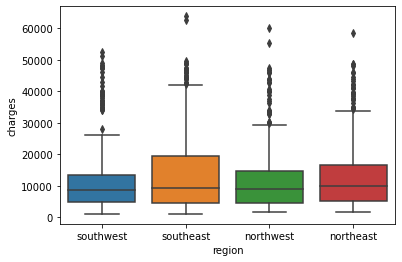

In [172]:
sns.boxplot(x="region", y="charges", data=df);

**Very little difference between regions and insurance premiums. I'm guessing this variable is not very important.**

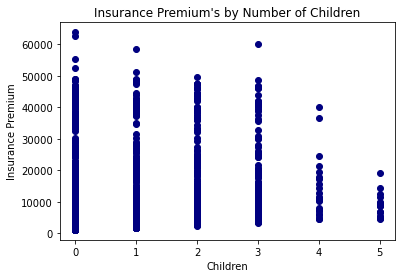

In [46]:
x_children = df.children
y_charges = df.charges
plt.plot(x_children, y_charges, 'o', color='navy');
plt.xlabel("Children");
plt.ylabel("Insurance Premium");
plt.title("Insurance Premium's by Number of Children");

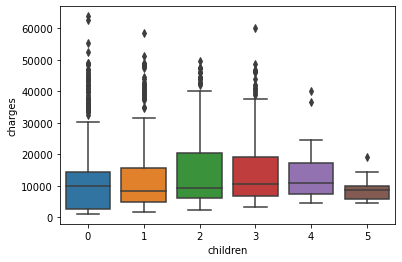

In [178]:
sns.boxplot(x="children", y="charges", data=df);

**People with fewer children pay higher insruance premiums (That's surprising)**

In [63]:
#Defining function: 
def create_val_splits(df, val_units=15, return_val=False):
    train = df.groupby('id').apply(lambda x: x.iloc[:-val_units]).reset_index(drop=True)
    test  = df.groupby('id').apply(lambda x: x.iloc[-val_units:]).reset_index(drop=True)
    if return_val:
        val   = train.groupby('id').apply(lambda x: x.iloc[-val_units:]).reset_index(drop=True)
        train = train.groupby('id').apply(lambda x: x.iloc[:-val_units]).reset_index(drop=True)
        return train, val, test
    else:
        return train, test

In [74]:
#Initial fitting
train, val, test = train_validate_test_split(df)

# create a pipeline, and get our model score
pipe = make_pipeline(ce.TargetEncoder(), GradientBoostingRegressor())

# split into X & y
X_train, y_train = train.drop('charges', axis=1), train['charges']
X_val, y_val = val.drop('charges', axis=1), val['charges']

# fit & score
pipe.fit(X_train, y_train)
pipe.score(X_train, y_train), pipe.score(X_val, y_val)

(0.9188725077512243, 0.8578457210824242)

**Comparing the test score vs validation just to make sure they're somewhat similar. 
Base line R-squared is 0.858 (already quite high)** 

In [183]:
# df['Predictions'] = 1
# df['Section'] = None
# df.loc[ X_train.index, 'Prediction'] = pipe.predict(X_train)
# df.loc[X_train.index, 'Section'] = 'Train'
# df.head()

,age,sex,bmi,children,smoker,region,charges,Predictions,Section,Prediction
0,19,female,27.900,0,yes,southwest,16884.92400,1,None,NaN
1,18,male,33.770,1,no,southeast,1725.55230,1,None,NaN
2,28,male,33.000,3,no,southeast,4449.46200,1,None,NaN
3,33,male,22.705,0,no,northwest,21984.47061,1,None,NaN
4,32,male,28.880,0,no,northwest,3866.85520,1,Train,4756.013336


In [103]:
#Testing new parameters
n_estimators  = [50, 100, 150, 200, 250]
learning_rate = [.05, .1, .2]
max_depth     = [3, 4, 5, 6]
cv_scores     = []

# and cycle through our model parameters
for estimators in n_estimators:
    for rate in learning_rate:
        for depth in max_depth:
            print(f"Fitting model with parameters:  n_estimators - {estimators}, learning_rate - {rate}, max_depth - {depth}")
            mod   = GradientBoostingRegressor(n_estimators=estimators, learning_rate=rate, max_depth=depth, max_features=0.6)
            pipe  = make_pipeline(ce.TargetEncoder(), mod)
            pipe.fit(X_train, y_train)
            score = pipe.score(X_val, y_val)
            print(f"Out-of-sample score: {score}")
            cv_scores.append((score, estimators, rate, depth))

Fitting model with parameters:  n_estimators - 50, learning_rate - 0.05, max_depth - 3
Out-of-sample score: 0.8445509981152637
Fitting model with parameters:  n_estimators - 50, learning_rate - 0.05, max_depth - 4
Out-of-sample score: 0.8475211322723047
Fitting model with parameters:  n_estimators - 50, learning_rate - 0.05, max_depth - 5
Out-of-sample score: 0.8511606296528653
Fitting model with parameters:  n_estimators - 50, learning_rate - 0.05, max_depth - 6
Out-of-sample score: 0.8461863246730498
Fitting model with parameters:  n_estimators - 50, learning_rate - 0.1, max_depth - 3
Out-of-sample score: 0.8608088135389426
Fitting model with parameters:  n_estimators - 50, learning_rate - 0.1, max_depth - 4
Out-of-sample score: 0.85569826141655
Fitting model with parameters:  n_estimators - 50, learning_rate - 0.1, max_depth - 5
Out-of-sample score: 0.8471517681436224
Fitting model with parameters:  n_estimators - 50, learning_rate - 0.1, max_depth - 6
Out-of-sample score: 0.8334534

In [108]:
#Best parameters: 
max(cv_scores)

(0.8608088135389426, 50, 0.1, 3)

**Fitting model with parameters:  n_estimators - 50, learning_rate - 0.1, max_depth - 3
Out-of-sample score: 0.8608088135389426**

In [132]:
pipe[1].set_params(n_estimators=50, max_depth=3, learning_rate=0.1)
train, val, test= train_validate_test_split(df)

X_train, y_train = train.drop('charges', axis=1), train['charges']
X_test, y_test   = test.drop('charges', axis=1), val['charges']

pipe.fit(X_train, y_train)
pipe.score(X_val, y_val)
#Note sure why this doesn't match the results from above... should be 0.861 an increase from our baseline of 0.858

0.8541663433416058

In [113]:
feats = pd.DataFrame({ 'Importance': pipe.steps[1][1].feature_importances_, 'Column': X_test.columns})
feats.sort_values(by='Importance', ascending=False)

,Importance,Column
4,0.703785,smoker
2,0.148709,bmi
0,0.130911,age
3,0.012333,children
5,0.003729,region
1,0.000533,sex


**As expected, the top three most important variables are smokers, BMI, and age. You can interpret this as: smokers, BMI, and age explain roughly 98% of the model. We could probably drop age and region from the model**

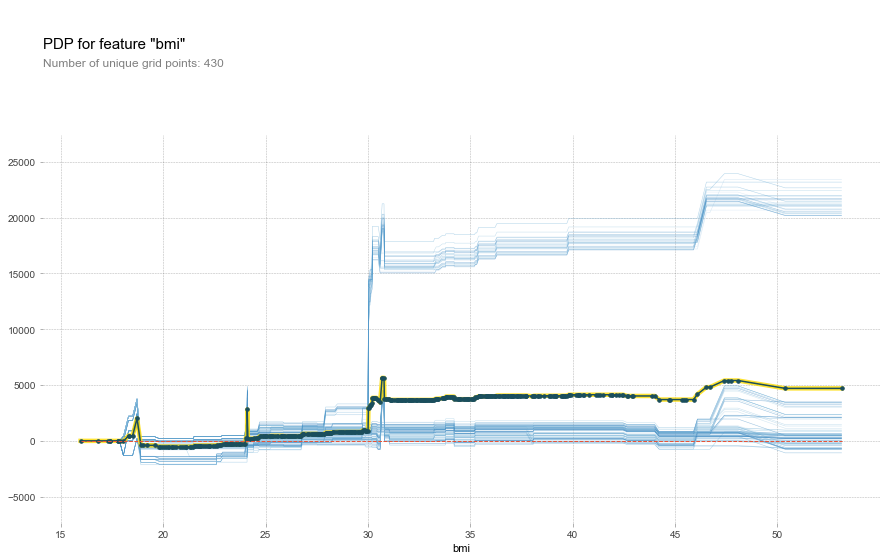

In [143]:
pdp_bmi = pdp.pdp_isolate(
    model=pipe[1], dataset=pipe[0].transform(X_train), model_features=X_train.columns.tolist(), 
    feature='bmi', cust_grid_points = pipe[0].transform(X_train)['bmi'].tolist()
)

fig, axes = pdp.pdp_plot(pdp_bmi, 'bmi', plot_lines=True, frac_to_plot=100)

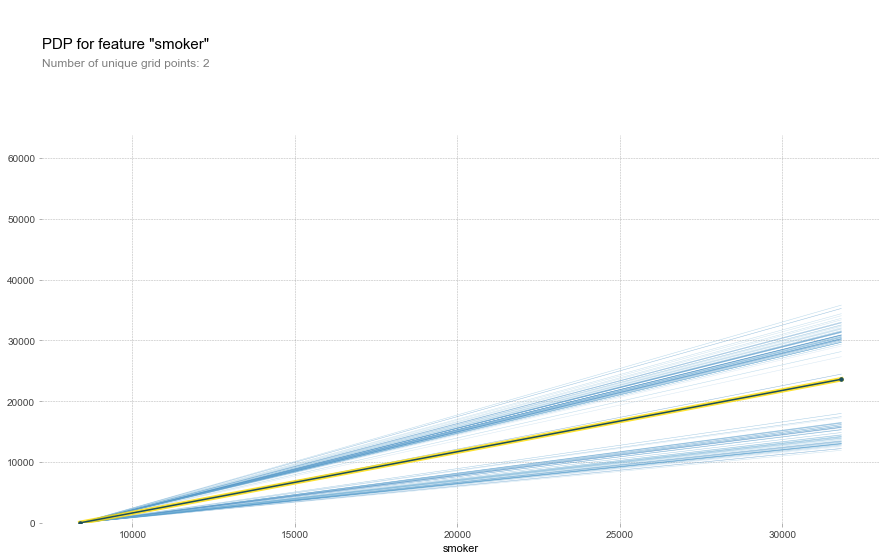

In [180]:
pdp_smoker= pdp.pdp_isolate(
    model=pipe[1], dataset=pipe[0].transform(X_train), model_features=X_train.columns.tolist(), 
    feature='smoker', cust_grid_points = pipe[0].transform(X_train)['smoker'].tolist()
)

fig, axes = pdp.pdp_plot(pdp_smoker, 'smoker', plot_lines=True, frac_to_plot=100)

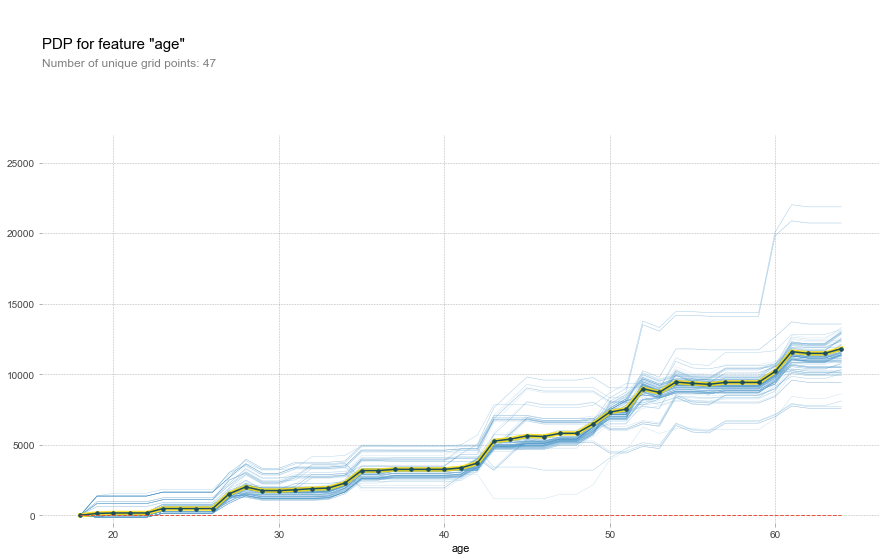

In [186]:
pdp_age= pdp.pdp_isolate(
    model=pipe[1], dataset=pipe[0].transform(X_train), model_features=X_train.columns.tolist(), 
    feature='age', cust_grid_points = pipe[0].transform(X_train)['age'].tolist()
)

fig, axes = pdp.pdp_plot(pdp_age, 'age', plot_lines=True, frac_to_plot=100)

**This visual sort of matches the scatter plot from the beginning showing how BMI breaks up into two groups around 30 BMI.**

In [7]:
# and a slightly different look at the same problem
gbm_inter = pdp.dp_interact(
    model=pipe[1], dataset=pipe[0].transform(X_train), model_features=pipe[0].get_feature_names(), 
    features=['bmi', 'smokers']
)

fig, axes = pdp.pdp_interact_plot(
    gbm_inter, ['bmi', 'smokers'], x_quantile=True, plot_type='grid', plot_pdp=True
)

AttributeError: module 'pdpbox.pdp' has no attribute 'dp_interact'

**Final Comments: my final model explains 86% of my datas variance with the three primary important variables being smoking, bmi, and age. It seems an increase in either of these traits leads to higher premiums, amd BMI clearly being effected by another variable. I think including more variables perhaps preexisting conditions or employeed/nonemployeed would be interesting to see how it helps prediction**